# Word2vec context nearest neighbour model

In [1]:
#package to load word2vec vectors
import gensim
from gensim.models.keyedvectors import KeyedVectors
#self built functions
import utilities
#semcor corpus
import nltk
from nltk.corpus import semcor
from nltk.corpus import wordnet as wn
#Micellaneous
import numpy as np
import collections
from scipy.spatial.distance import cosine
import sys
import re
import time
import progressbar
import pickle
from functools import partial

In [2]:
#Load word2vec binary file
model = KeyedVectors.load_word2vec_format('../datasets/word2vec/GoogleNews-vectors-negative300.bin', binary=True)
#Define embedding_dict
embedding_dict = model.word_vec
#Load semcor
tagged_chunks = semcor.tagged_chunks(tag='sem')

In [21]:
example_sent = semcor.tagged_sents(tag='both')[0]

In [26]:
example_sent_untagged = semcor.sents()[0]
' '.join(example_sent_untagged)

"The Fulton County Grand Jury said Friday an investigation of Atlanta 's recent primary election produced `` no evidence '' that any irregularities took place ."

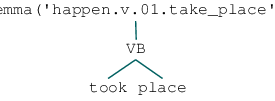

In [32]:
example_sent[-2]

In [80]:
#prediction method
def predict(context,predict_lemmas):
    #senses_choices must be a python list of sense label (wordnet synset)
    #get context embedding
    context_emb = getContextEmb_word2vec(context=context,emb_size=300,embedding_dict=embedding_dict)
    #get senses choice
    synsets = wn.synsets(predict_lemmas)
    senses_choices = [synset.name() for synset in synsets]
    #calculate cosine distance between each sense and context
    decision_chart = [[choice,cosine(context_emb,sense_embeddings[choice])] for choice in senses_choices]
    prediction = sorted(decision_chart,key=lambda x:x[1])[0][0]
    return prediction
def get_context(tagged_chunks,position,window_size):
    center = tagged_chunks[position].leaves()
    num_words = 0
    iter_position = position
    #unroll left size
    left = []
    right = []
    while (num_words<window_size):
        iter_position-=1
        if iter_position <0:
            break
        item = tagged_chunks[iter_position]
        if type(item)==list:
            num_words +=1
            left.insert(0,item[0])
        elif type(item)==nltk.tree.Tree:
            words2append = item.leaves()
            if num_words+len(words2append)>window_size:
                num_allowed = window_size-num_words
                words2append=words2append[-num_allowed:]
            num_words += len(words2append)
            left = words2append+left
            
    num_words = 0
    iter_position = position
    while (num_words<window_size):
        iter_position+=1
        if iter_position >=len(tagged_chunks):
            break
        item = tagged_chunks[iter_position]
        if type(item)==list:
            num_words +=1
            right.append(item[0])
        elif type(item)==nltk.tree.Tree:
            words2append = item.leaves()
            if num_words+len(words2append)>window_size:
                num_allowed = window_size-num_words
                words2append=words2append[:num_allowed]
            num_words += len(words2append)
            right = right+words2append
    return left+center+right

def getContextEmb_word2vec(context,embedding_dict,emb_size,unk_emb=np.zeros(300)):
    # Input introductions
    # sentence: an array of tokens of untagged sentence. 
    # center: position of the center word
    # window_size: size of context window
    # embedding_Dict: gensim model method
    ################################################################
        output_embedding = np.zeros(emb_size)
        for word in context:
            try:
                output_embedding+=embedding_dict(word)#use gensim model method
            except:
                output_embedding+=unk_emb
        return output_embedding
    
def buildSemEmb_word2vec(tagged_chunks,embedding_dict,emb_size=300,window_size=4):
    progress = progressbar.ProgressBar(max_value=len(tagged_chunks))
    output_dict = collections.defaultdict(partial(np.zeros,emb_size))
    for idx in range(len(tagged_chunks)):
        progress.update(idx)
        itm=tagged_chunks[idx]
        if(type(itm))==list:
            continue
        else:
            #Use try except handling since some of the label is broken
            try:
                sense_index = itm.label().synset().name()
            except:
                continue
            context = get_context(position=idx,tagged_chunks=tagged_chunks,window_size=window_size)
            context_emb = getContextEmb_word2vec(context,embedding_dict=embedding_dict,emb_size=300)
            output_dict[sense_index]+=context_emb
    return output_dict
def buildSemEmb_word2vec_gloss(tagged_chunks,embedding_dict,emb_size=300,threshold=0.5):
    progress = progressbar.ProgressBar(max_value=len(tagged_chunks))
    output_dict = collections.defaultdict(partial(np.ones,emb_size))
    for idx in range(len(tagged_chunks)):
        progress.update(idx)
        itm = tagged_chunks[idx]
        if(type(itm))==list:
            continue
        else:
            #Use try except handling since some of the label is broken
            try:
                sense_synset = itm.label().synset()
            except:
                continue
            if sense_synset.name() in output_dict:
                continue
            predicted_lemmas_emb = getContextEmb_word2vec(itm.leaves(),embedding_dict,300)
            gloss = sense_synset.definition()
            closest_gloss_emb_dist = None
            closest_gloss_emb = None
            gloss_count = 0
            for word in gloss:
                try:
                    word_emb = embedding_dict(word)
                except:
                    continue
                dist = cosine(word_emb,predicted_lemmas_emb)
                if closest_gloss_emb_dist==None:
                    closest_gloss_emb_dist = dist
                    closest_gloss_emb = word_emb
                if dist<closest_gloss_emb_dist:
                    closest_gloss_emb_dist  = dist
                    closest_gloss_emb = word_emb
                if dist<threshold:
                    gloss_count+=1
                    output_dict[sense_synset.name()]+=closest_gloss_emb
            if gloss_count==0:
                #print(type(closest_gloss_emb))
                output_dict[sense_synset.name()]+=closest_gloss_emb
    return output_dict

In [88]:
sense_embeddings_gloss = buildSemEmb_word2vec_gloss(tagged_chunks,embedding_dict=embedding_dict,emb_size = 300,threshold=0.6)

N/A% (0 of 778587) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/zhuorulin/anaconda/envs/py35/lib/python3.5/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
 99% (777825 of 778587) |################# | Elapsed Time: 0:02:45 ETA: 0:00:00

In [91]:
sense_embeddings = sense_embeddings_gloss

In [29]:
predict

0.35493030592145003

In [5]:
#build sense embeddings
#sense_embeddings = buildSemEmb_word2vec(tagged_chunks=tagged_chunks,embedding_dict=embedding_dict)

In [28]:
sense_embeddings_train_win5 = buildSemEmb_word2vec(tagged_chunks=tagged_chunks[:600000],embedding_dict=embedding_dict,window_size=5)

 99% (599953 of 600000) |################# | Elapsed Time: 0:15:06 ETA: 0:00:00

In [14]:
sense_embeddings_train2_win5 = buildSemEmb_word2vec(tagged_chunks=tagged_chunks[150000:],embedding_dict=embedding_dict,window_size=5)

 99% (628564 of 628587) |################# | Elapsed Time: 0:10:50 ETA: 0:00:00

In [90]:
sense_embeddings = sense_embeddings_train2_win5

NameError: name 'sense_embeddings_train2_win5' is not defined

In [328]:
f = open('sense_win5.pk','wb')
pickle.dump(obj=sense_mebeddings_win5,file=f)

In [329]:
f.close()

In [7]:
f = open('sense_win5.pk','rb')
sense_embeddings = pickle.load(f)

# Attempt: trying to classify some ambiguous word

In [8]:
#Example test
example = tagged_chunks[:30]
context = get_context(position=5,tagged_chunks=example,window_size=5)
print('lemma to predict:%s'%(example[5]))
print('context:%s'%(' '.join(context)))
senses_choices = example[5]
print()
print('Final decision: %s'%(predict(context=context,predict_lemmas='investigation')))

lemma to predict:(Lemma('probe.n.01.investigation') investigation)
context:Grand Jury said Friday an investigation of Atlanta 's recent primary

Final decision: probe.n.01


## Notice how closed possible senses are

In [ ]:
print(wn.synsets('investigation')[0])
print(wn.synsets('investigation')[0].definition())

In [ ]:
print(wn.synsets('investigation')[1])
print(wn.synsets('investigation')[1].definition())

# Perform all-words WSD

In [69]:
def predict_all(tagged_chunks,window_size = 4):
    progress = progressbar.ProgressBar(max_value=len(tagged_chunks))
    num_correct = 0
    num_predicted = 0.0
    for idx in range(len(tagged_chunks)):
        progress.update(idx)
        itm=tagged_chunks[idx]
        if (idx%100000==0)&(num_predicted>0):
            print('correct: %s, predicted: %s, accuracy: %s'%(num_correct,num_predicted,num_correct/num_predicted))
        if(type(itm))==list:
            continue
        else:
            #Use try except handling since some of the label is broken
            try:
                lemma = itm.label().name()
            except:
                continue
            context = get_context(position=idx,tagged_chunks=tagged_chunks,window_size=window_size)
            prediction = predict(context=context,predict_lemmas=lemma)
            correct = itm.label().synset().name()
            num_predicted +=1
            if prediction == correct:
                num_correct+=1
    return num_correct/num_predicted
def predict_baseline(tagged_chunks,window_size = 4):
    progress = progressbar.ProgressBar(max_value=len(tagged_chunks))
    num_correct = 0
    num_predicted = 0.0
    for idx in range(len(tagged_chunks)):
        progress.update(idx)
        itm=tagged_chunks[idx]
        if (idx%100000==0)&(num_predicted>0):
            print('correct: %s, predicted: %s, accuracy: %s'%(num_correct,num_predicted,num_correct/num_predicted))
        if(type(itm))==list:
            continue
        else:
            #Use try except handling since some of the label is broken
            try:
                lemma = itm.label().name()
            except:
                continue
            synsets = wn.synsets(lemma)
            senses_choices = [synset.name() for synset in synsets]
            prediction = senses_choices[0]
            correct = itm.label().synset().name()
            num_predicted +=1
            if prediction == correct:
                num_correct+=1
    return num_correct/num_predicted

In [70]:
len(tagged_chunks)

778587

In [92]:
predict_all(tagged_chunks=tagged_chunks[:10000])

 99% (9993 of 10000) |#################### | Elapsed Time: 0:00:20 ETA: 0:00:00

0.504769805060141

In [25]:
# Window size 4 should get 68.3% accuracy.
predict_all(tagged_chunks,window_size=5)

N/A% (0 of 778587) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/zhuorulin/anaconda/envs/py35/lib/python3.5/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
 12% (100068 of 778587) |##                | Elapsed Time: 0:04:04 ETA: 0:27:35

correct: 35611, predicted: 46755.0, accuracy: 0.7616511603037108


 25% (200044 of 778587) |####              | Elapsed Time: 0:07:40 ETA: 0:22:11

correct: 66617, predicted: 90254.0, accuracy: 0.7381057903250825


 38% (300078 of 778587) |######            | Elapsed Time: 0:11:49 ETA: 0:18:51

correct: 99284, predicted: 134788.0, accuracy: 0.7365937620559694


 51% (400072 of 778587) |#########         | Elapsed Time: 0:15:36 ETA: 0:14:40

correct: 130896, predicted: 178290.0, accuracy: 0.7341746592629985


 64% (500421 of 778587) |###########       | Elapsed Time: 0:16:31 ETA: 0:08:50

correct: 138952, predicted: 193085.0, accuracy: 0.7196416086179662


 77% (600628 of 778587) |#############     | Elapsed Time: 0:17:01 ETA: 0:04:41

correct: 143980, predicted: 203822.0, accuracy: 0.7064006829488475


 89% (700597 of 778587) |################  | Elapsed Time: 0:17:32 ETA: 0:01:45

correct: 149102, predicted: 214747.0, accuracy: 0.6943147052112486


 99% (778374 of 778587) |################# | Elapsed Time: 0:18:00 ETA: 0:00:00

0.6827996226347923

In [63]:
predict_baseline(tagged_chunks[600000:],window_size=5)

 56% (101727 of 178587) |##########        | Elapsed Time: 0:00:09 ETA: 0:00:06

correct: 2295, predicted: 10925.0, accuracy: 0.21006864988558352


 99% (177854 of 178587) |################# | Elapsed Time: 0:00:16 ETA: 0:00:00

0.1977601225232124

In [31]:
sense_embeddings = sense_embeddings_win5

In [46]:
predict_all(tagged_chunks[600000:],window_size=5)

N/A% (0 of 178587) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/zhuorulin/anaconda/envs/py35/lib/python3.5/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
 56% (100675 of 178587) |##########        | Elapsed Time: 0:00:32 ETA: 0:00:25

correct: 5122, predicted: 10925.0, accuracy: 0.46883295194508007


 99% (178332 of 178587) |################# | Elapsed Time: 0:01:02 ETA: 0:00:00

0.4525701158227242

In [45]:
predict_baseline(tagged_chunks[600000:])

 56% (101727 of 178587) |##########        | Elapsed Time: 0:00:09 ETA: 0:00:07

correct: 2295, predicted: 10925.0, accuracy: 0.21006864988558352


 99% (177404 of 178587) |################# | Elapsed Time: 0:00:17 ETA: 0:00:00

0.1977601225232124

In [12]:
predict_baseline(tagged_chunks[:150000])

 67% (100633 of 150000) |############      | Elapsed Time: 0:00:30 ETA: 0:00:14

correct: 26806, predicted: 46755.0, accuracy: 0.5733290557159662


 99% (149842 of 150000) |################# | Elapsed Time: 0:00:43 ETA: 0:00:00

0.5670554567922647

In [16]:
predict_all(tagged_chunks[:150000],window_size=5)

N/A% (0 of 150000) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/zhuorulin/anaconda/envs/py35/lib/python3.5/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
 66% (100067 of 150000) |############      | Elapsed Time: 0:04:04 ETA: 0:02:04

correct: 27789, predicted: 46755.0, accuracy: 0.594353545075393


 99% (149954 of 150000) |################# | Elapsed Time: 0:05:55 ETA: 0:00:00

0.5862348061107979